Andrew Pan

This work is licensed under a [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/)

# Computational Bayesian Statistics Report 4

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math, sys, thinkplot
import numpy as np
import pandas as pd

from itertools import product

from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeGammaPmf, MakeMixture, MakePoissonPmf, EvalWeibullPdf, EvalWeibullCdf, MakeBinomialPmf, EvalNormalPdf, EvalExponentialPdf

# Bayes Theorem Problems

## Hospital Problem

From http://www.programminglogic.com/bayes-theorem-with-examples/

Suppose you are a hospital manager, and you are considering the use of a new method to diagnose a rare form of bowel syndrome. You know that only 0,1% of the population suffers from that disease. You also know that if a person has the disease, the test has 99% of chance of turning out positive. If the person doesn’t have the disease, the test has a 98% chance of turning negative.

How feasible is this diagnostics method? That is, given that a test turned out positive, what are the chances of the person really having the disease?

### Answer

To determine the probability of a positive result from the test actually indicating that the subject has bowel syndrome, we first need to determine our prior hypotheses.  In this problem, there are only two hypotheses: the patient either has this rare form of bowel syndrome, or doesn't.  The probability of having the disease is 0.1%, thus the probability of not having the disease is 99.9%.  We'll use a Pmf object to help solve this problem.

In [2]:
bowelSyndrome = Pmf()
bowelSyndrome['disease'] = .001
bowelSyndrome['no disease'] = .999

Next we need to update our priors with the likelihoods of the data.  The data in this problem is that the test is positive, so we need to multiply the values in our Pmf by the likelihoods of a positive test result for each hypotheses.  There is a 99% positive test result for patients with the disease, and a 98% negative test result for patients without, which equates to a 2% chance for healthy patients.  Multiplying our priors by these likelihoods yields our unnormalized posterior data.

In [3]:
bowelSyndrome['disease'] *= .99
bowelSyndrome['no disease'] *= .02

Now all we have to do is normalize our Pmf.

In [4]:
bowelSyndrome.Normalize()
bowelSyndrome.Print()

disease 0.047210300429184546
no disease 0.9527896995708154


So getting a positive result on the test means that a patient only actually has a 4.2% probability of actually having this rare bowel syndrome!

## FIFA Problem

In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Note: for this one you will need a new suite that provides a Likelihood function that takes as data the time between goals, rather than the number of goals in a game. 

### Answer

To determine the probability distribution of goals Germany will score by 90 minutes, we need to first define a set of prior hypotheses of Germany's goals per game.  In the 2014 World Cup leading up to the Brazil-Germany match, Germany had a running average of 2 goals per game.  To model the probability of goals Germany will score, we can use a gamma distribution with a lambda value of 2, their running average.

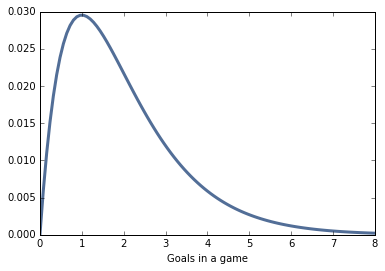

In [5]:
xs = np.linspace(0, 8, 101)
pmf = MakeGammaPmf(xs, 2) # goal average for 2014 world cup up until this game
thinkplot.Pdf(pmf)
thinkplot.Config(xlabel='Goals in a game')

Now that we have our prior hypotheses, we can define a class that extends Suite to update our prior with the data from this game so far.  The time between goals follows an exponential distribution, so for our likelihood function we can use the EvalExponentialPdf function.  After creating an instance of our class with our prior hypotheses, we can update it with the times that goals were scored in this game (relative to the entire length of the game).

3.12836636747


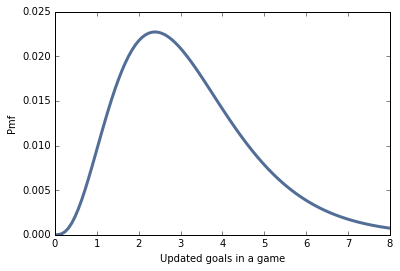

In [6]:
class germanyGoals(Suite):

    def Likelihood(self, data, hypo):
        """
        data: time between scored goals with respect to game duration
        hypo: lambda
        
        returns: the probability of time between goals for the given lambda hypothesis
        """
        return EvalExponentialPdf(data, hypo)
    
g = germanyGoals(pmf)
g.Update(11/90)
g.Update(12/90)
thinkplot.Pdf(g)
thinkplot.config(xlabel = 'Updated goals in a game', ylabel = 'Pmf')
print(g.Mean())

We now have our updated distribution for the expected number of goals Germany would score against Brazil in a game, for which the mean value is about 3 goals.  However, we need to determine the probabilities for the number of goals Germany will score after their first two goals against Brazil.  To do this, we need to create a mixture of pmfs following a Poisson distribution to model the goal scoring process.  We can make use of the MakePoissonPmf function to create Poisson distributions for each posterior hypothesis for goals per game, and use the algorithm from the MakeMixture function to sum the probabilities of Germany's remaining goals for this game from each Poisson distribution, weighted by the probability of that Poisson distribution.  Since we are already 23 minutes into the game, we have to create our Poisson distributions with a hypothesis weighted for the remaining 67 minutes.

2.32115006214


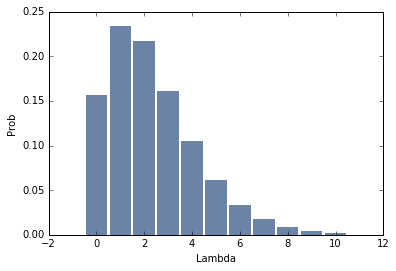

In [7]:
metapmf = Pmf({MakePoissonPmf(hypo * 67/90, 10): prob for hypo, prob in g.Items()})
mix = Pmf()
for pmf, p1 in metapmf.Items(): # used the algorithm from make mixture
    for x, p2 in pmf.Items():
        if(p1 != 0):
            mix[x] += p1 * p2
thinkplot.Hist(mix)
thinkplot.config(xlabel = 'Lambda', ylabel = 'Prob')
print(mix.Mean())

So the mean number of goals Germany can be expected to score in the remainder of the game is 2.3.  All that's left is to find the probability of Germany scoring 5 goals, for which we can use the Pmf's Prob function.

In [8]:
print(mix.Prob(5))

0.0616184827386


Thus the outcome that occured in the 2014 World Cup match had a 6.16% probability of occuring at the 23 minute mark.

## Lightbulb Prediction Problem

Suppose we know that, for a particular kind of lightbulb in a particular location, the distribution of lifespans is well modeled by a Weibull distribution with lam=2 and k=1.5. If we install n=100 lightbulbs and come back one year later, what is the distribution of c, the number of lightbulbs that have burned out?

### Answer

To create our distribution, we can use the MakeBinomialPmf function that takes the total number of lightbulbs, 100, and the probability of EvalWeibullCdf given lambda and k values as arguments.  We use EvalWeibullCdf because we are looking for the total number of lightbulbs burnt out over the course of the year, not any individual case in the timespan, so we also use 1 as the first argument to the function to represent one year.

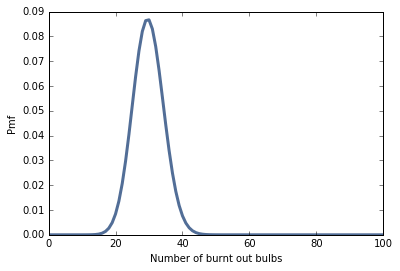

In [15]:
from thinkbayes2 import MakeBinomialPmf, EvalWeibullCdf
thinkplot.Pdf(MakeBinomialPmf(100, EvalWeibullCdf(1, 2, 1.5)))
thinkplot.Config(xlabel = "Number of burnt out bulbs", ylabel = "Pmf")

Now suppose that lam and k are not known precisely, but we have a LightBulb object that represents the joint posterior distribution of the parameters after seeing some data. Compute the posterior predictive distribution for c, the number of bulbs burned out after one year.

### Answer

The first thing we have to do is set up our LightBulb object and populate it with data following the steps in survival.ipynb.

In [10]:
def SampleWeibull(lam, k, n=1):
    return np.random.weibull(k, size=n) * lam

lam = 2
k = 1.5
n = 15
t_end = 10
starts = np.random.uniform(0, t_end, n)
lifespans = SampleWeibull(lam, k, n)

df = pd.DataFrame({'start': starts, 'lifespan': lifespans})
df['end'] = df.start + df.lifespan
df['age_t'] = t_end - df.start

data = []
for i, row in df.iterrows():
    if row.end < t_end:
        data.append(('eq', row.lifespan))
    else:
        data.append(('gt', row.age_t))
        

class LightBulb(Suite, Joint):
    def Likelihood(self, data, hypo):
        flag, x = data
        if hypo[0] == 0:
            return 0
        if flag == 'eq':
            return EvalWeibullPdf(x, hypo[0], hypo[1])
        elif flag == 'gt':
            return 1 - EvalWeibullCdf(x, hypo[0], hypo[1])
        elif flag == 'bo':
            return EvalWeibullCdf(x, hypo[0], hypo[1])
        else:
            print('Could not read data')
            sys.exit()
            

lams = np.linspace(0, 10, 101)
ks = np.linspace(0, 10, 101)

lb = LightBulb(product(lams, ks))
lb.UpdateSet(data)

1.0583885880896688e-09

Next, we already know that our LightBulb object contains the joint probability distributions for the lambda and k parameters of Weibull distributions.  To compute the posterior predictive distribution for the number of lightbulbs burnt out after one year, we need to create a metapmf.  This metapmf maps a pmf for each of the hypotheses in our LightBulb object to the probability of the hypotheses.  To create our sub-pmfs, we can use the same process that we did for distribution in the last problem.

In [11]:
metapmf = Pmf({MakeBinomialPmf(100, EvalWeibullCdf(1, hypo[0], hypo[1])): prob for hypo, prob in lb.Items()})

Now all we have to do is use the MakeMixture function on our metapmf to obtain the distribution of lightbulbs that have burnt out over the course of one year.

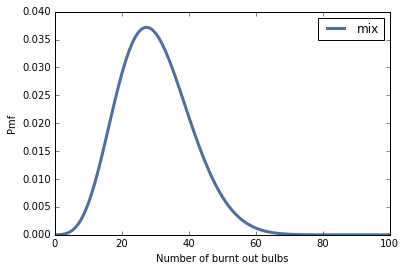

In [12]:
thinkplot.Pdf(MakeMixture(metapmf))
thinkplot.Config(xlabel = "Number of burnt out bulbs", ylabel = "Pmf")

# Original Bayes Theorem Problem

## Magical Dice Problem

One day on his way home from school, Billy found a shiny jewel on the side of the road.  Upon closer inspection, it turned out to be not a jewel, but a 100-sided die, and a magic one at that!  Each time Billy rolled the die, the values close to the value that landed face up became more likely to be rolled for all future rolls.  Billy managed to roll only prime numbers from 1 to 100, and rolled each prime exactly once.  Can you create a probability distribution to predict Billy's next roll?

### Answer

To solve this problem, we can begin by creating a class that extends Suite.  The only function from the Suite class that needs to be changed is the Likelihood function.  We need to make the Likelihood function increase the probability of values close to the rolled number, which in this case is the data argument.  Fortunately, the EvalNormalPdf function can be used to provide us with the necessary likelihoods since it returns the Pdf of the data from a normal distribution centered about its second argument.  Its third argument is used in scipy.stats.norm.pdf to scale the distribution, so in this case we want that scaling value to be the maximum difference between the data and hypothesis, 99.

In [13]:
class magicDie(Suite):
    def Likelihood(self, data, hypo):
        return EvalNormalPdf(data, hypo, 99)    

Now that we have our class, we just have to update it with all of the prime numbers that Billy rolled.

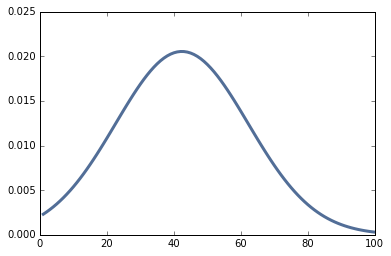

In [14]:
primes = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
mD = magicDie(range(1, 101))
for p in primes:
    mD.Update(p)
thinkplot.Pdf(mD)

And there's our probability distribution for Billy's next roll.  The distribution is shifted slightly to the left of the center of the graph because there are more prime numbers in the range of 1-50 than there are from 51-100, so Billy's next roll is slightly more likely to be less than 50 than it is to be above 50.